In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import norm
from data import wirtual
import random

In [11]:
wirtual_flat = [item for sublist in wirtual for item in sublist]
print(len(wirtual))

def rolling_avg(sequence, window_size):
    # Initialize the rolling average array
    rolling_avg = np.zeros_like(sequence, dtype=float)

    # Compute rolling average
    for i in range(len(sequence)):
        if i < window_size - 1:
            # For the first few elements, average the elements from the start to the current position
            rolling_avg[i] = np.mean(sequence[:i+1])
        else:
            # For the rest, compute the average of the window
            rolling_avg[i] = np.mean(sequence[i-window_size+1:i+1])
    return rolling_avg

def rolling_avg_both_sides(sequence, window_size):
    # Initialize the rolling average array
    rolling_avg = np.zeros_like(sequence, dtype=float)

    # Compute rolling average
    for i in range(len(sequence)):
        start = i-window_size//2+1
        end = start+window_size
        if start<0:
            start=0
        if end > len(sequence):
            end=len(sequence)
        rolling_avg[i] = np.mean(sequence[start:end])
    return rolling_avg

def rolling_avg_both_sides_asym(sequence, left, right):
    # Initialize the rolling average array
    rolling_avg = np.zeros_like(sequence, dtype=float)

    # Compute rolling average
    for i in range(len(sequence)):
        start = i-left
        end = i+right+1
        if start<0:
            start=0
        if end > len(sequence):
            end=len(sequence)
        rolling_avg[i] = np.mean(sequence[start:end])
    return rolling_avg

def remove_repeated_elements(arr):
    if not arr:
        return []
    result = [arr[0]]
    for el in arr:
        if el != result[-1]:
            result.append(el)
    return result

def exp_smoothing_average(sequence, alpha=0.05):
    avg = np.zeros_like(sequence, dtype=float)
    for i in range(1, len(sequence)):
        avg[i] = alpha*sequence[i] + (1-alpha)*(avg[i-1])
    return avg

def logistic_curve(n, low, high, shift, speed):
    return low + (high-low) / (1 + np.exp(-speed * (n-shift)))

def loss_logistic(params, sequence):
    low, high, shift, speed = params
    n = np.arange(len(sequence))
    predicted_probs = logistic_curve(n, low, high, shift, speed)
    loss = np.mean((sequence - predicted_probs)**2)
    return np.sum(loss)

def neg_log_likelihood(params, sequence):
    low, high, shift, speed = params
    n = np.arange(len(sequence))
    predicted_probs = logistic_curve(n, low, high, shift, speed)
    predicted_probs = np.clip(predicted_probs, 0.00000001, 0.99999999)
    loss = np.sum(-(sequence * np.log(predicted_probs) + (1-sequence) * np.log(1-predicted_probs)))
    return loss    

class Floor:
    
    def __init__(self):
        self.floor = None
        self.successes = None
        self.params = None
        self.rolling_avg = None
        self.fail_distribution = None
        self.is_based_on_data = None
            
    @classmethod
    def from_data(cls, data, floor):
        obj = Floor()
        obj.is_based_on_data = True
        obj.floor = floor
        
        # Calculate successes and fail distribution
        obj.successes = []
        obj.fail_distribution = {i: 0 for i in range(floor+1)}
        for i in range(len(data)-1):
            if data[i] == floor:
                if data[i+1] == floor+1:
                    obj.successes.append(1)
                else:
                    obj.successes.append(0)
                    obj.fail_distribution[data[i+1]] += 1
        obj.successes = np.array(obj.successes)
                    
        # Compute rolling average
        window_size = 20
        obj.rolling_avg = rolling_avg(obj.successes, window_size)
        #obj.prob = rolling_avg_both_sides_asym(obj.successes, 40, 10)
        #obj.prob = exp_smoothing_average(obj.successes)
        
        # Train model
        initial_params = [0.0, 0.7, 0.9, 0.9]
        bounds = [(-10, 1), (0, 1), (-100, 300), (0, 30)]
        result = minimize(neg_log_likelihood, initial_params, args=(obj.successes,), bounds=bounds, method='L-BFGS-B')
        #result = minimize(loss_logistic, initial_params, args=(obj.prob,), method='L-BFGS-B')
        if result.success:
            obj.params = result.x
        else:
            print("Optimization failed:", result.message)
        return obj
            
    @classmethod
    def from_params(cls, floor, low, high, shift, speed):
        obj = Floor()
        obj.floor = floor
        obj.is_based_on_data = False
        obj.successes = list(range(100))
        obj.params = (low, high, shift, speed)
        obj.fail_distribution = {i:1 for i in range(floor)}
        return obj
            
    def simulate_one_step(self, attempt):
        p = logistic_curve(attempt, *self.params)
        if random.random() <= p:
            return self.floor + 1
        else:
            keys = list(self.fail_distribution.keys())
            weights = list(self.fail_distribution.values())
            sample = random.choices(keys, weights=weights, k=1)[0]
            return sample
            
    def plot(self):
        # Generate x values
        if self.rolling_avg is not None:
            x_values = np.arange(len(self.rolling_avg))
        else:
            x_values = np.arange(200)

        low, high, shift, speed = self.params

        # Calculate y values
        y_values = logistic_curve(x_values, low, high, shift, speed)

        # Plotting the result
        plt.figure(figsize=(10, 3))
        plt.plot(x_values, y_values, label='Logistic Curve')
        if self.rolling_avg is not None:
            plt.plot(x_values, self.rolling_avg, label="Rolling Average")
        plt.title(f'Floor {self.floor}')
        plt.xlabel('Attempts')
        plt.ylabel('Success Probability')
        plt.ylim(0, 1.05)
        plt.grid(True)
        plt.legend()
        plt.show()

131


In [12]:
wirtual_flat = remove_repeated_elements(wirtual_flat)
wirtual_first_time_reached_floor = []
for i in range(18):
    try:
        wirtual_first_time_reached_floor.append(wirtual_flat.index(i))
    except:
        pass
wirtual_first_time_reached_floor

floor = 1
for i, hour in enumerate(wirtual):
    if floor in hour:
        print(f"Floor {floor} reached after {i} hours.")
        floor += 1

if floor < 17:
    print(f"Floor {floor} NOT reached yet, {len(wirtual)} hours.")
            

Floor 1 reached after 0 hours.
Floor 2 reached after 1 hours.
Floor 3 reached after 5 hours.
Floor 4 reached after 7 hours.
Floor 5 reached after 16 hours.
Floor 6 reached after 18 hours.
Floor 7 reached after 34 hours.
Floor 8 reached after 55 hours.
Floor 9 reached after 67 hours.
Floor 10 reached after 75 hours.
Floor 11 reached after 84 hours.
Floor 12 NOT reached yet, 131 hours.


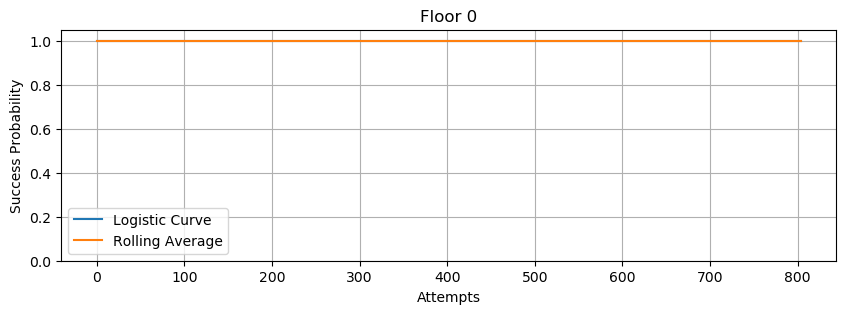

low=1.00, high=1.00, shift=-0.60, speed=1.28


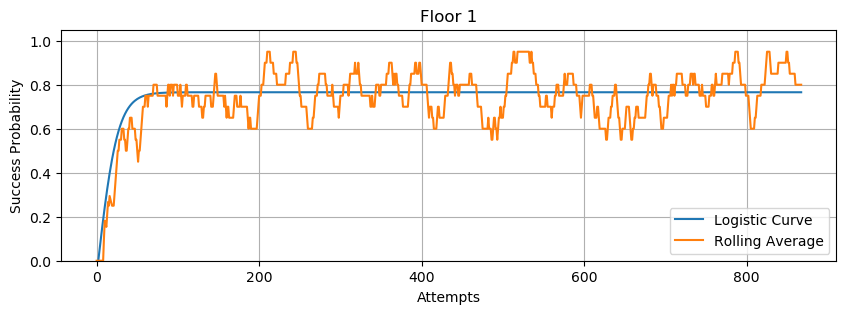

low=-0.83, high=0.77, shift=0.98, speed=0.08


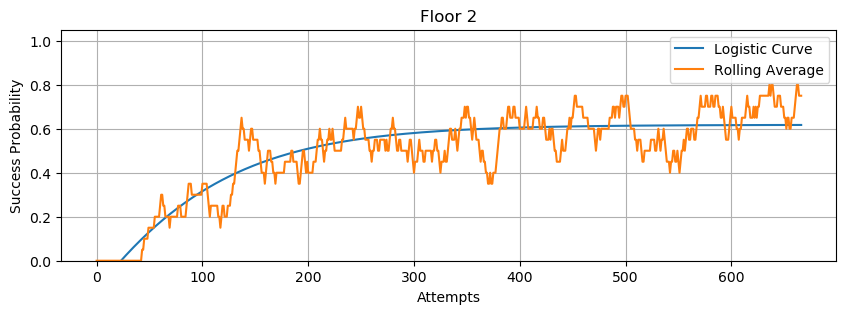

low=-2.37, high=0.62, shift=-100.00, speed=0.01


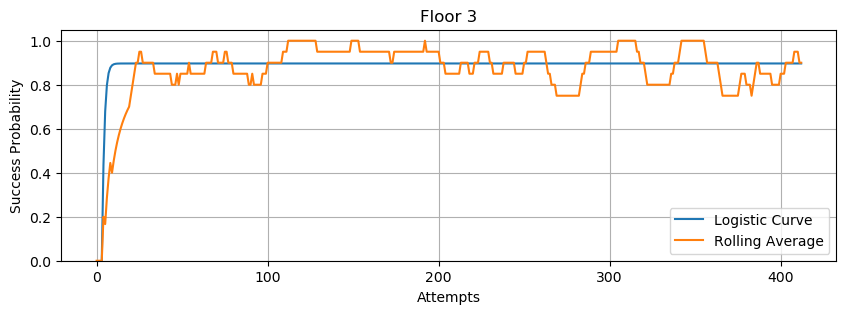

low=-2.52, high=0.90, shift=1.75, speed=0.83


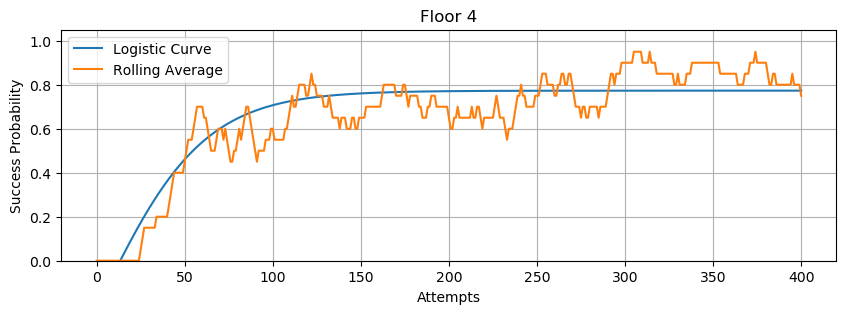

low=-1.16, high=0.77, shift=1.36, speed=0.03


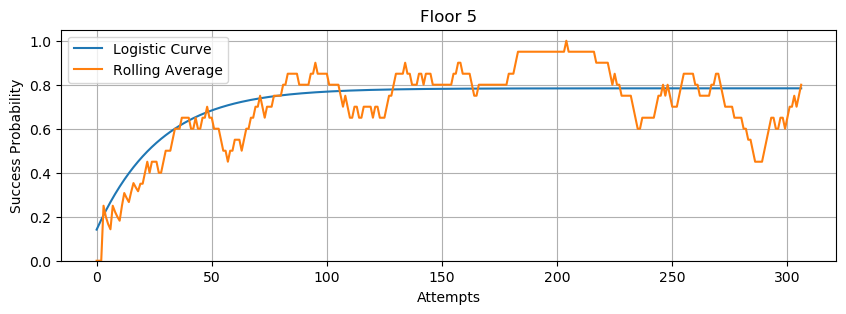

low=-10.00, high=0.78, shift=-72.32, speed=0.04


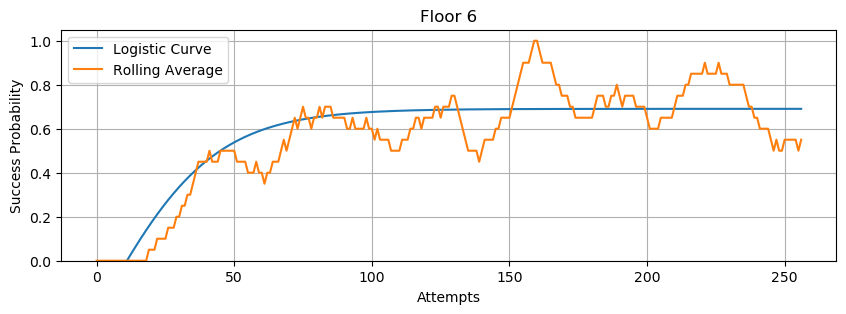

low=-1.11, high=0.69, shift=1.34, speed=0.05


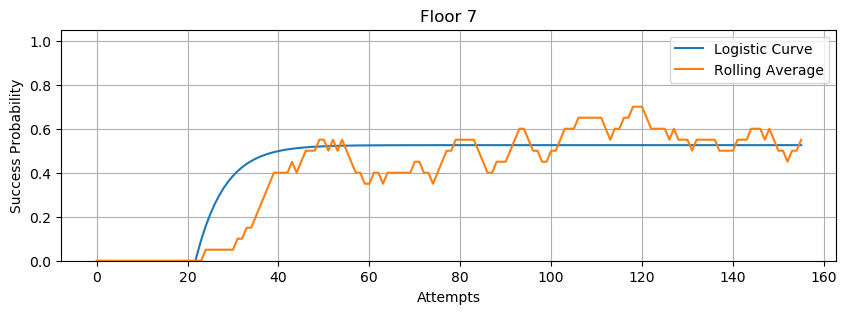

low=-9.34, high=0.53, shift=4.36, speed=0.17


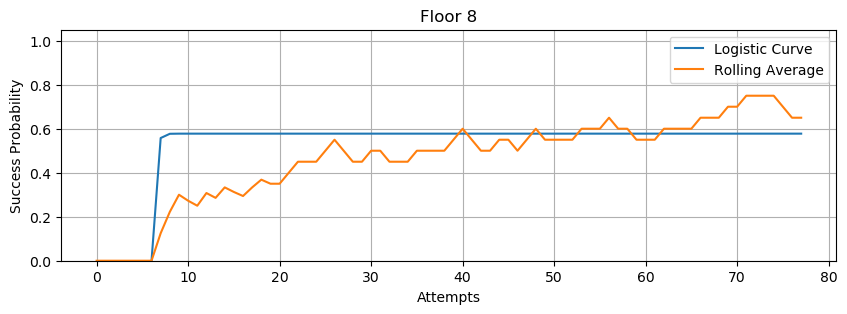

low=-6.01, high=0.58, shift=5.32, speed=3.46


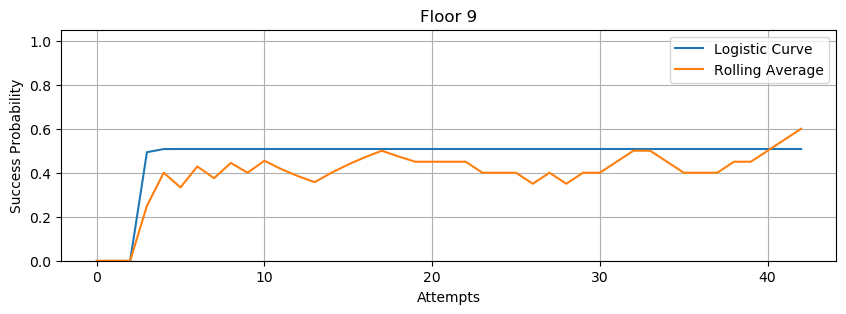

low=-1.45, high=0.51, shift=1.73, speed=3.86


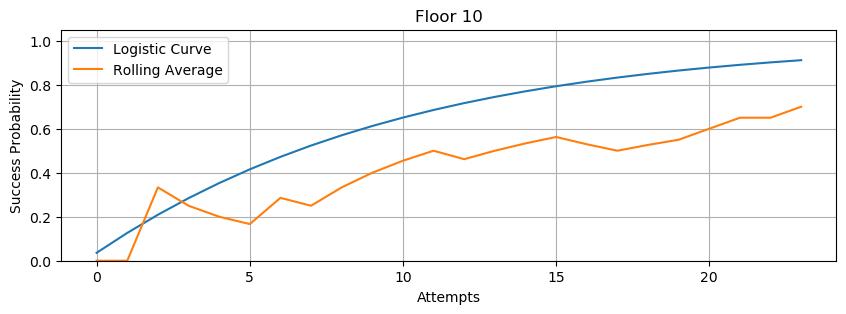

low=-10.00, high=1.00, shift=-21.80, speed=0.11


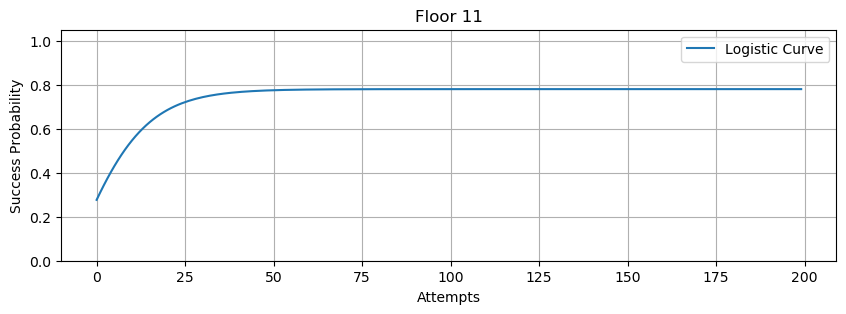

low=-0.77, high=0.78, shift=-7.32, speed=0.10


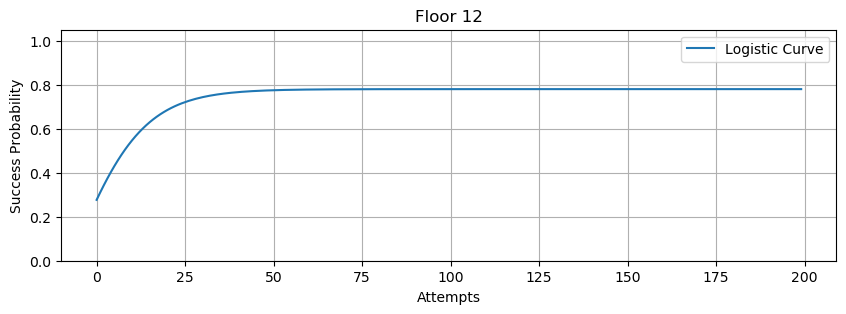

low=-0.77, high=0.78, shift=-7.32, speed=0.10


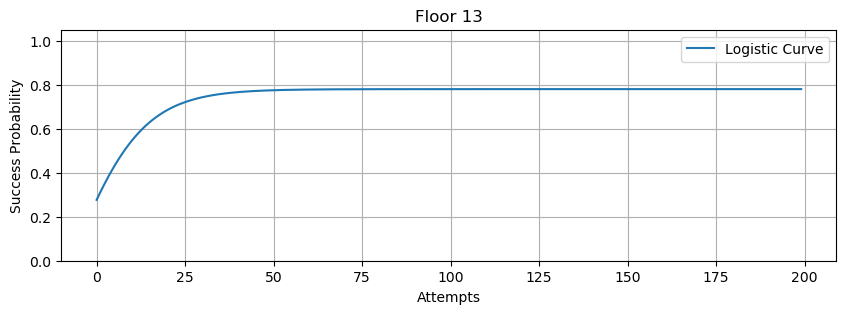

low=-0.77, high=0.78, shift=-7.32, speed=0.10


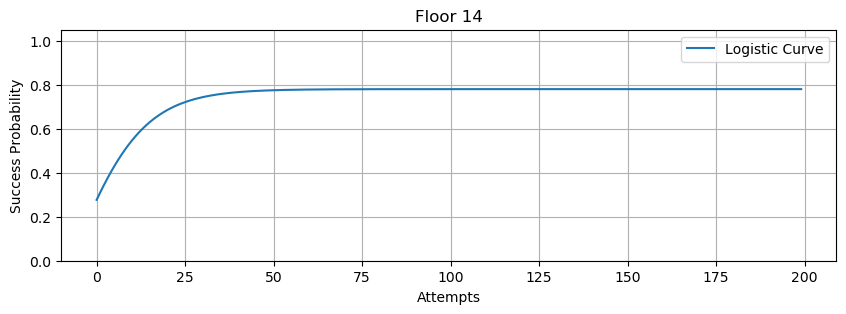

low=-0.77, high=0.78, shift=-7.32, speed=0.10


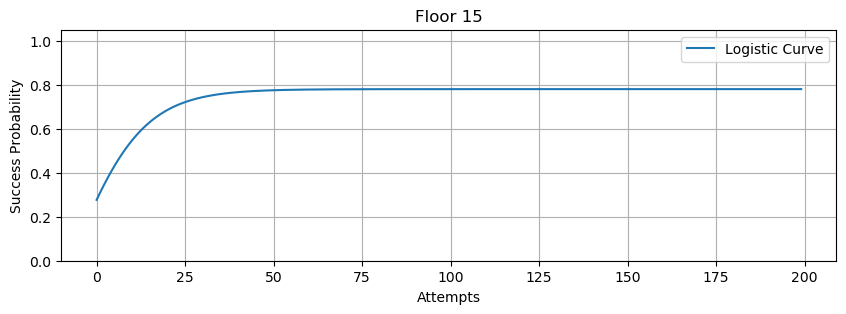

low=-0.77, high=0.78, shift=-7.32, speed=0.10


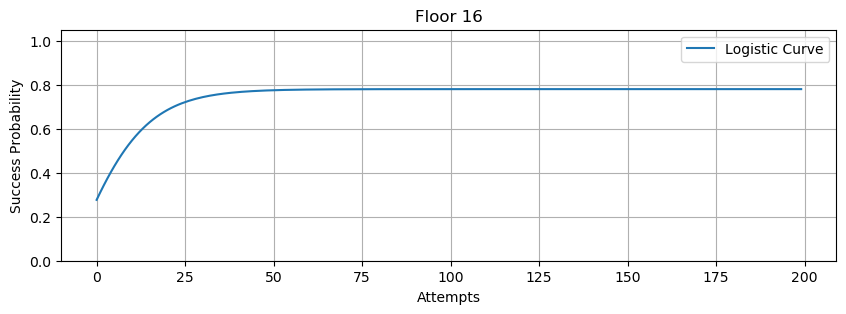

low=-0.77, high=0.78, shift=-7.32, speed=0.10


In [14]:
floors = []
for i in range(11):
    floors.append(Floor.from_data(wirtual_flat, i))
    
for i in range(11, 17):
    floors.append(Floor.from_params(i, -0.77, 0.78, -7.32, 0.1))
    
for floor in floors:
    floor.plot()
    print(f"low={floor.params[0]:.2f}, high={floor.params[1]:.2f}, shift={floor.params[2]:.2f}, speed={floor.params[3]:.2f}")

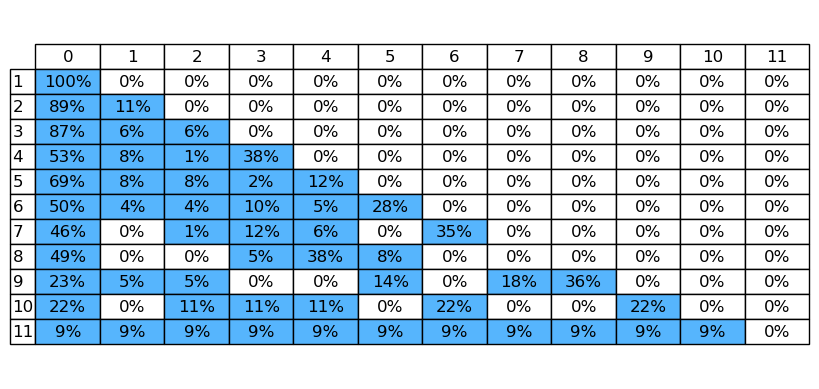

In [51]:
fail_distribution_matrix = []
size = 12
for i in range(1,size):
    row = []
    for j in range(size):
        row.append(floors[i].fail_distribution.get(j, 0))
    fail_distribution_matrix.append(row)
fail_distribution_matrix = np.array(fail_distribution_matrix)
row_sums = fail_distribution_matrix.sum(axis=1, keepdims=True)
normalized_fail_distribution_matrix = fail_distribution_matrix / row_sums
percentage_data = np.vectorize(lambda x: f'{x * 100:.0f}%')(normalized_fail_distribution_matrix)

num_rows, num_cols = percentage_data.shape
row_labels = [str(i) for i in range(1,num_rows+1)]
col_labels = [str(i) for i in range(num_cols)]

fig, ax = plt.subplots()
# Hide axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create table
table = plt.table(cellText=percentage_data, cellLoc='center', rowLabels=row_labels, colLabels=col_labels, loc='center', colWidths=[0.13] * normalized_fail_distribution_matrix.shape[1])

# Set font size
table.auto_set_font_size(False)
table.set_fontsize(12)

# Adjust column width
table.scale(1, 1.5)

# Color the cells
for i in range(normalized_fail_distribution_matrix.shape[0]):
    for j in range(normalized_fail_distribution_matrix.shape[1]):
        cell = table[(i+1, j)]
        if normalized_fail_distribution_matrix[i, j] != 0:
            cell.set_facecolor('#56b5fd')
        else:
            cell.set_facecolor('white')

plt.show()

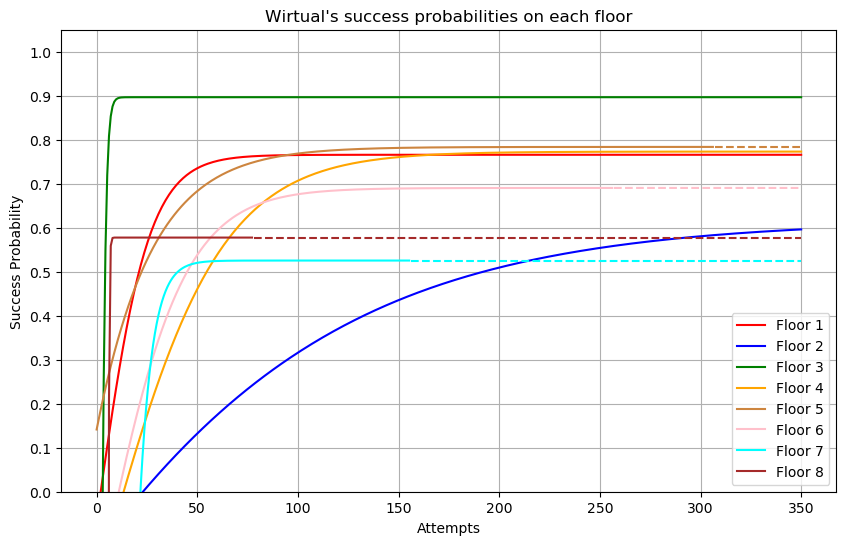

In [5]:
# Plot all floor probabilities in one plot
from matplotlib.ticker import MultipleLocator
x_values = np.linspace(0, 350, 400)
plt.figure(figsize=(10, 6))
plt.title(f'Wirtual\'s success probabilities on each floor')
plt.xlabel('Attempts')
plt.ylabel('Success Probability')
# Set the y-axis major ticks locator to be at intervals of 0.1
y_major_locator = MultipleLocator(0.1)
plt.gca().yaxis.set_major_locator(y_major_locator)
plt.ylim(0, 1.05)
plt.grid(True)
colors = ["red", "blue", "green", "orange", "peru", "pink", "cyan", "brown", "turquoise", "purple"]
for i, floor in enumerate(floors[1:9]):
    # Calculate y values
    low, high, shift, speed = floor.params
    split = len(floor.successes)
    y_values = logistic_curve(x_values, low, high, shift, speed)
    plt.plot(x_values[x_values<=split], y_values[x_values<=split], "b-", color=colors[i], label=f'Floor {floor.floor}')
    plt.plot(x_values[x_values>split], y_values[x_values>split], "b--", color=colors[i], label=None)
plt.legend()
plt.show()

In [18]:
prod = 1.0
for i in range(17):
    prod *= floors[i].params[1]
    print(f"Assuming enough practice, the chance to go through to floor {i+1} without fall: {prod*100:.2f}%")

Assuming enough practice, the chance to go through to floor 1 without fall: 100.00%
Assuming enough practice, the chance to go through to floor 2 without fall: 76.58%
Assuming enough practice, the chance to go through to floor 3 without fall: 47.31%
Assuming enough practice, the chance to go through to floor 4 without fall: 42.42%
Assuming enough practice, the chance to go through to floor 5 without fall: 32.79%
Assuming enough practice, the chance to go through to floor 6 without fall: 25.70%
Assuming enough practice, the chance to go through to floor 7 without fall: 17.74%
Assuming enough practice, the chance to go through to floor 8 without fall: 9.32%
Assuming enough practice, the chance to go through to floor 9 without fall: 5.38%
Assuming enough practice, the chance to go through to floor 10 without fall: 2.73%
Assuming enough practice, the chance to go through to floor 11 without fall: 2.73%
Assuming enough practice, the chance to go through to floor 12 without fall: 2.13%
Assum

In [7]:
results = []
for sim in range(1000):
    attempts = {i:0 for i in range(17)}
    first_time_reached_floor = [0]
    highest_reached_floor = 0
    current_floor = 0
    counter = 0
    while current_floor < 17:
        attempt_number = attempts[current_floor]
        new_floor = floors[current_floor].simulate_one_step(attempt_number)
        attempts[current_floor] += 1
        current_floor = new_floor
        counter += 1
        if current_floor > highest_reached_floor:
            highest_reached_floor = current_floor
            first_time_reached_floor.append(counter)
    results.append(first_time_reached_floor)
    if sim % 100 == 0:
        print(f"Simulations done: {sim}")

Simulations done: 0
Simulations done: 100
Simulations done: 200
Simulations done: 300
Simulations done: 400
Simulations done: 500
Simulations done: 600
Simulations done: 700
Simulations done: 800
Simulations done: 900


FLOOR 1
Minimum number of steps: 1 (0 hours)
Mean number of steps: 1 (0 hours)
Maximum number of steps: 1 (0 hours)
Standard deviation: 0 (0 hours)
Actually first time reached: 0 hours


/home/leif/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


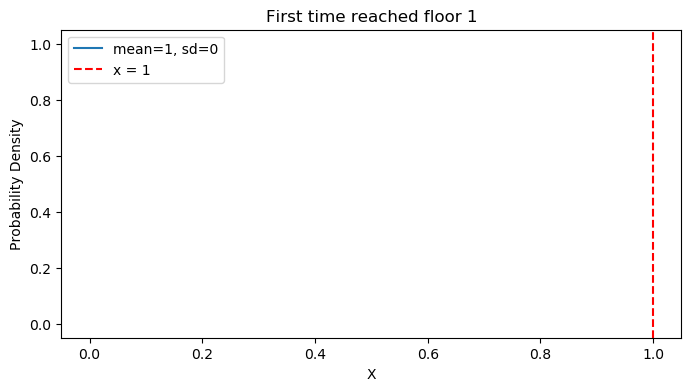

FLOOR 2
Minimum number of steps: 8 (0 hours)
Mean number of steps: 20 (1 hours)
Maximum number of steps: 48 (2 hours)
Standard deviation: 7 (0 hours)
Actually first time reached: 1 hours


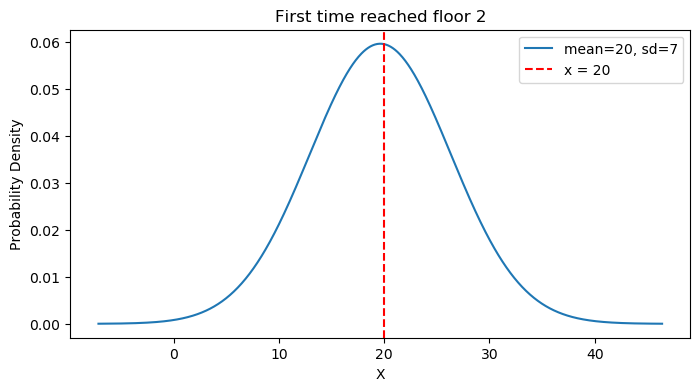

FLOOR 3
Minimum number of steps: 105 (3 hours)
Mean number of steps: 184 (6 hours)
Maximum number of steps: 318 (10 hours)
Standard deviation: 33 (1 hours)
Actually first time reached: 6 hours


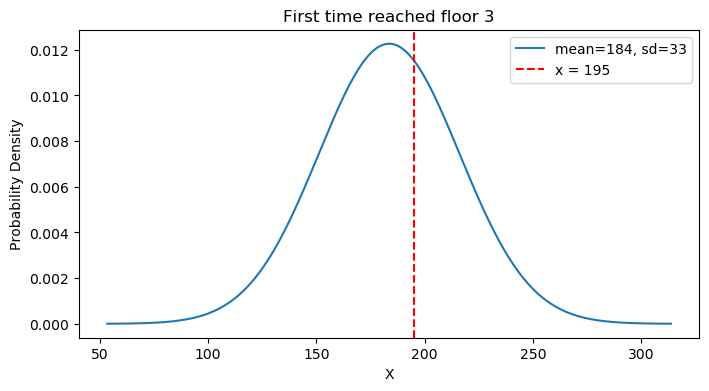

FLOOR 4
Minimum number of steps: 192 (6 hours)
Mean number of steps: 296 (10 hours)
Maximum number of steps: 466 (15 hours)
Standard deviation: 39 (1 hours)
Actually first time reached: 8 hours


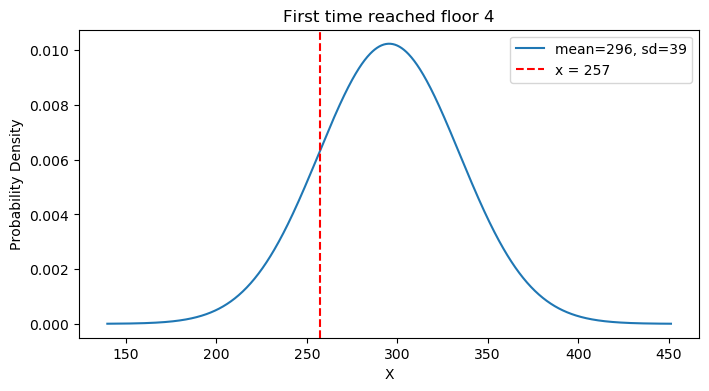

FLOOR 5
Minimum number of steps: 353 (11 hours)
Mean number of steps: 538 (17 hours)
Maximum number of steps: 788 (26 hours)
Standard deviation: 67 (2 hours)
Actually first time reached: 18 hours


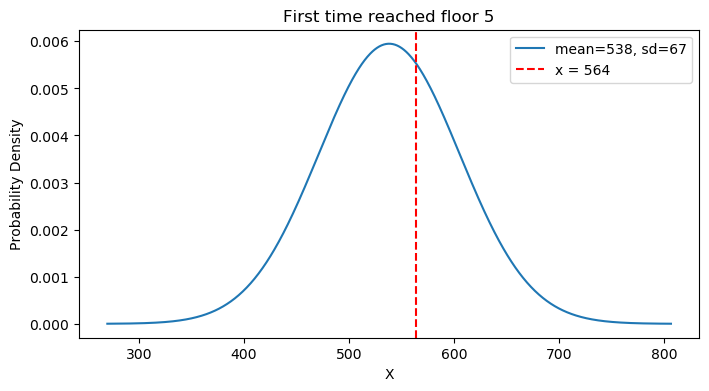

FLOOR 6
Minimum number of steps: 354 (11 hours)
Mean number of steps: 666 (22 hours)
Maximum number of steps: 964 (31 hours)
Standard deviation: 106 (3 hours)
Actually first time reached: 20 hours


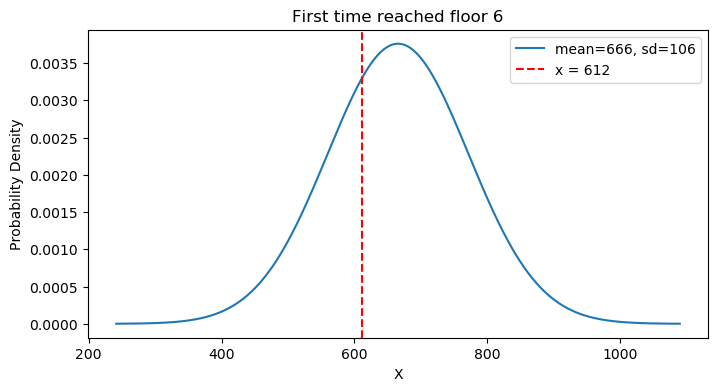

FLOOR 7
Minimum number of steps: 864 (28 hours)
Mean number of steps: 1202 (39 hours)
Maximum number of steps: 1562 (51 hours)
Standard deviation: 117 (4 hours)
Actually first time reached: 36 hours


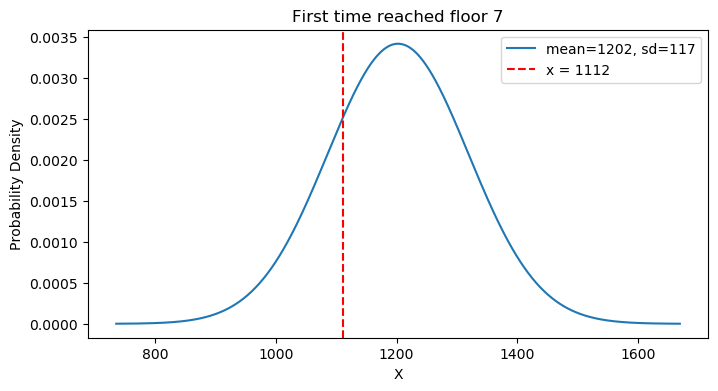

FLOOR 8
Minimum number of steps: 1500 (49 hours)
Mean number of steps: 1864 (61 hours)
Maximum number of steps: 2318 (75 hours)
Standard deviation: 138 (4 hours)
Actually first time reached: 58 hours


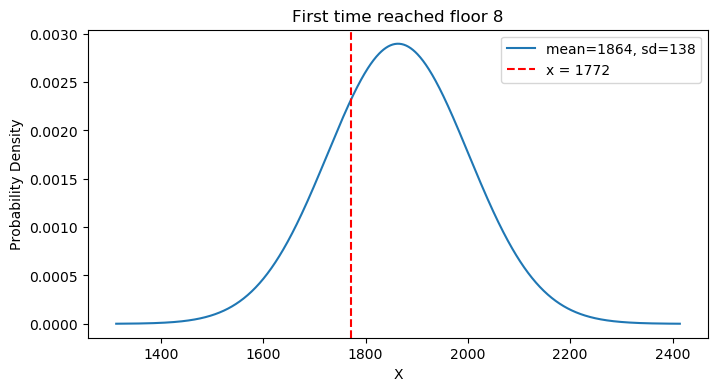

FLOOR 9
Minimum number of steps: 1722 (56 hours)
Mean number of steps: 2175 (71 hours)
Maximum number of steps: 2727 (89 hours)
Standard deviation: 166 (5 hours)
Actually first time reached: 69 hours


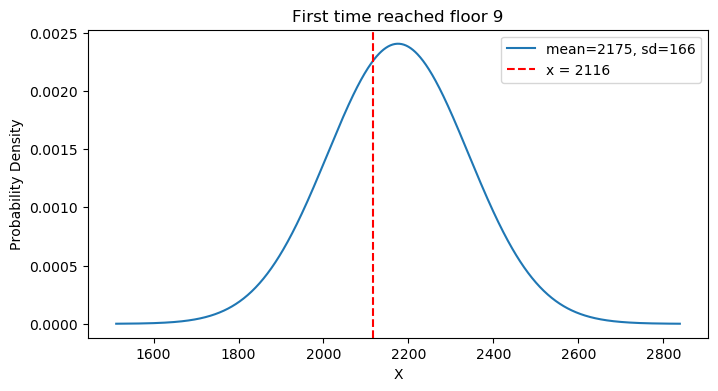

FLOOR 10
Minimum number of steps: 1777 (58 hours)
Mean number of steps: 2357 (77 hours)
Maximum number of steps: 3257 (106 hours)
Standard deviation: 204 (7 hours)
Actually first time reached: 77 hours


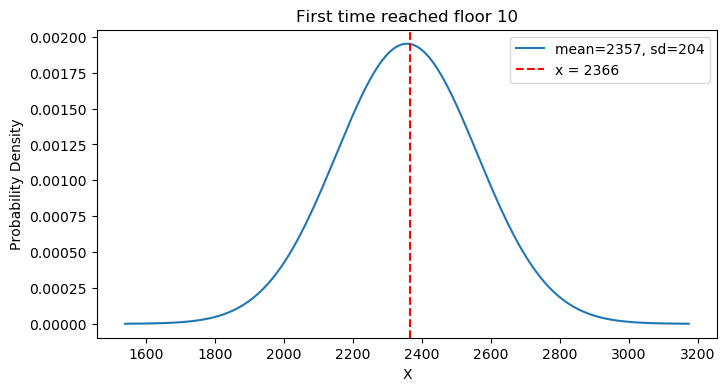

FLOOR 11
Minimum number of steps: 1893 (61 hours)
Mean number of steps: 2673 (87 hours)
Maximum number of steps: 4602 (149 hours)
Standard deviation: 318 (10 hours)
Actually first time reached: 86 hours


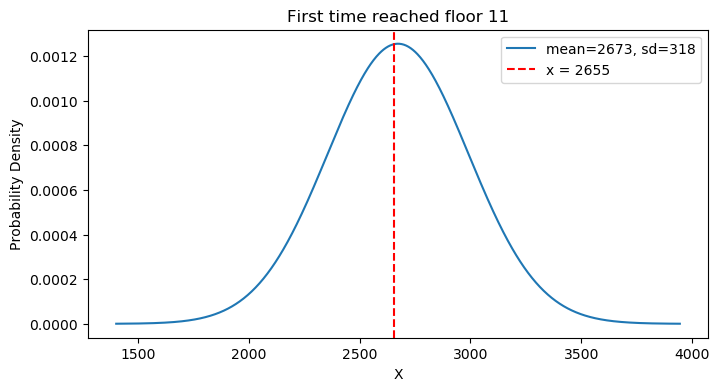

FLOOR 12
Minimum number of steps: 1951 (63 hours)
Mean number of steps: 2990 (97 hours)
Maximum number of steps: 5043 (164 hours)
Standard deviation: 460 (15 hours)


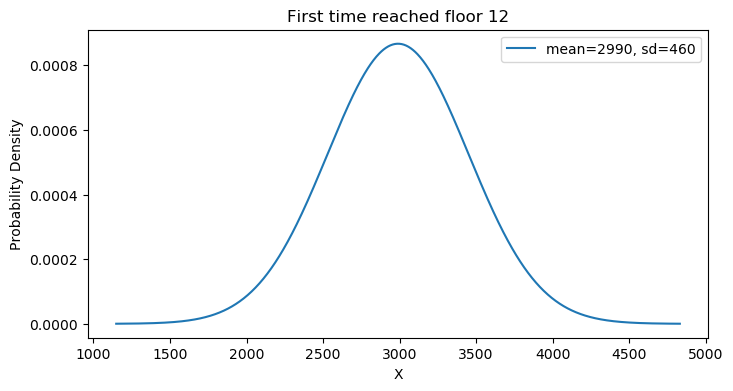

FLOOR 13
Minimum number of steps: 1952 (63 hours)
Mean number of steps: 3467 (113 hours)
Maximum number of steps: 6024 (196 hours)
Standard deviation: 639 (21 hours)


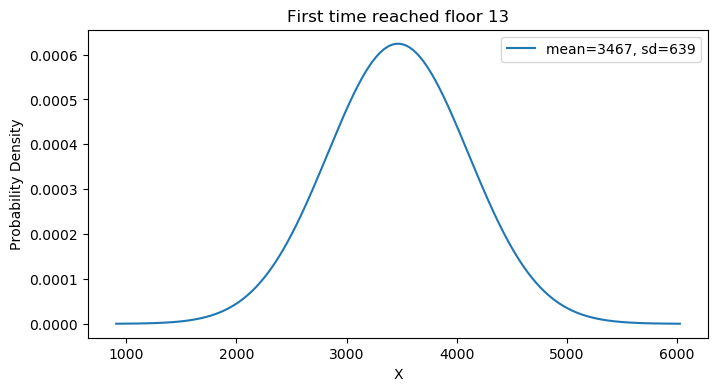

FLOOR 14
Minimum number of steps: 1953 (63 hours)
Mean number of steps: 4108 (133 hours)
Maximum number of steps: 7560 (245 hours)
Standard deviation: 879 (29 hours)


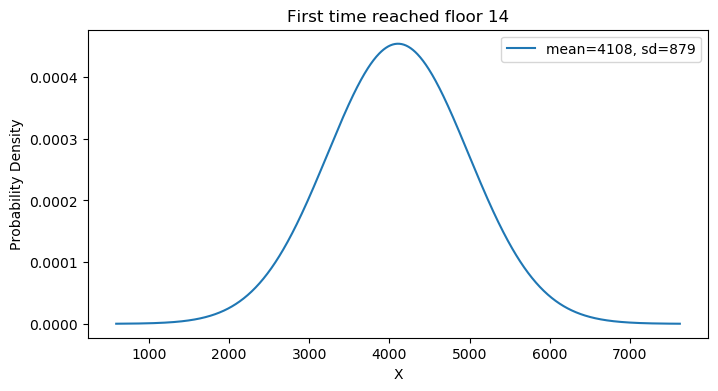

FLOOR 15
Minimum number of steps: 1954 (63 hours)
Mean number of steps: 4953 (161 hours)
Maximum number of steps: 9430 (306 hours)
Standard deviation: 1111 (36 hours)


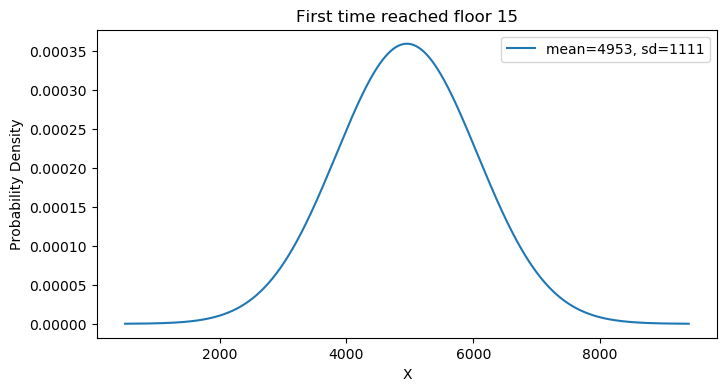

FLOOR 16
Minimum number of steps: 2460 (80 hours)
Mean number of steps: 6062 (197 hours)
Maximum number of steps: 11782 (383 hours)
Standard deviation: 1414 (46 hours)


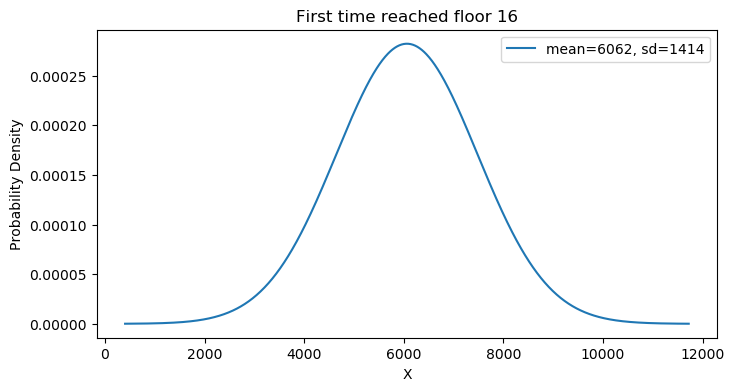

FLOOR 17
Minimum number of steps: 2461 (80 hours)
Mean number of steps: 7367 (239 hours)
Maximum number of steps: 14425 (468 hours)
Standard deviation: 1772 (58 hours)


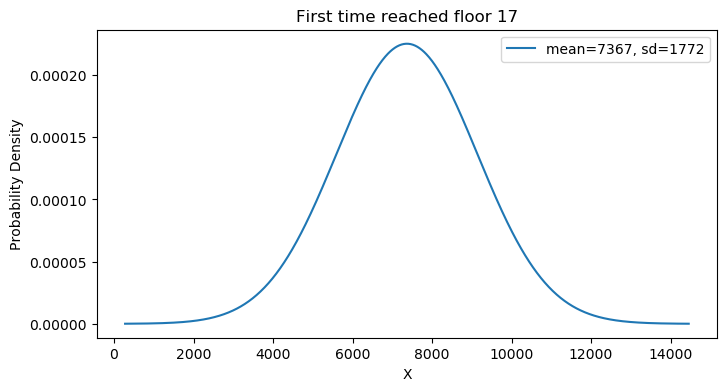

In [8]:
def gauss(mean, sd, title=None, highlight=None):
    x_values = np.linspace(mean - 4*sd, mean + 4*sd, 1000)
    y_values = norm.pdf(x_values, mean, sd)
    plt.figure(figsize=(8, 4))
    plt.plot(x_values, y_values, label=f'mean={mean:.0f}, sd={sd:.0f}')
    if highlight is not None:
        plt.axvline(x=highlight, color='r', linestyle='--', label=f'x = {highlight}')

    # Adding labels and title
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Probability Density')
    plt.legend()

    # Display the plot
    plt.show()

steps_per_hour = len(wirtual_flat) / len(wirtual)
for f in range(1, 18):
    reached_floor = [sim[f] for sim in results]
    mean_steps = np.mean(reached_floor)
    min_steps = np.min(reached_floor)
    max_steps = np.max(reached_floor)
    sd_steps = np.std(reached_floor)
    print(f"FLOOR {f}")
    print(f"Minimum number of steps: {min_steps:.0f} ({min_steps / steps_per_hour:.0f} hours)")
    print(f"Mean number of steps: {mean_steps:.0f} ({mean_steps / steps_per_hour:.0f} hours)")
    print(f"Maximum number of steps: {max_steps:.0f} ({max_steps / steps_per_hour:.0f} hours)")
    print(f"Standard deviation: {sd_steps:.0f} ({sd_steps / steps_per_hour:.0f} hours)")
    if f < len(wirtual_first_time_reached_floor):
        print(f"Actually first time reached: {wirtual_first_time_reached_floor[f] / steps_per_hour:.0f} hours")
        gauss(mean_steps, sd_steps, title=f"First time reached floor {f}", highlight=wirtual_first_time_reached_floor[f])
    else:
        gauss(mean_steps, sd_steps, title=f"First time reached floor {f}")